In [11]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedTopK
from torch_training import training_loop


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-07-16 12:18:30.242335: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 12:18:30.318368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 12:18:30.318398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 12:18:30.319715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 12:18:30.330226: I tensorflow/core/platform/cpu_feature_guar

In [3]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/synth_topk_torch_gf_1000'
exps = glob.glob(base_dir + '/*')

In [15]:
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500
K=4
seed=360
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)

2024-07-16 12:23:26.655792: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-16 12:23:26.655822: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-07-16 12:23:26.655827: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-07-16 12:23:26.655861: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-07-16 12:23:26.655886: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-07-16 12:23:26.655891: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [5]:
len(exps)

20

/cluster/tufts/hugheslab/kheuto01/synth_topk_torch_gf_1000/bw5000_nw1_ss0.1_th0.55


<Figure size 640x480 with 0 Axes>

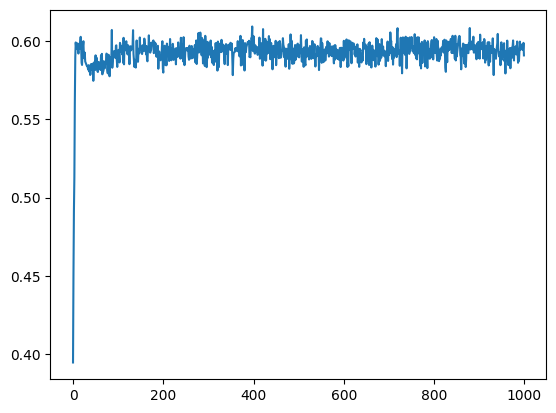

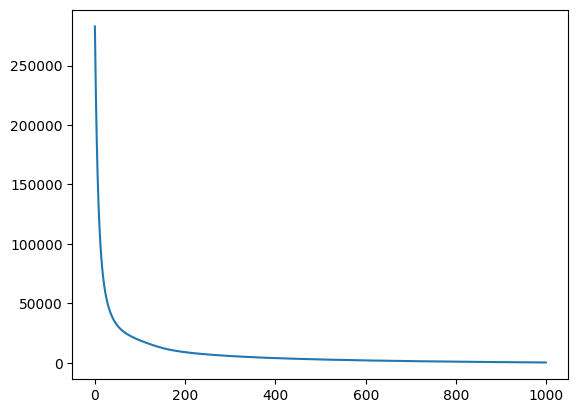

In [36]:
for exp in exps:
    if 'bw5000_nw1_ss0.1_th0.55' not in exp:
        continue
    plt.figure()
    model = MixtureOfTruncNormModel()
    model.load_state_dict(torch.load(exp + '/model.pth'))
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')
    losses = [loss.detach().numpy() for loss in losses]
    bprs = [bpr.detach().numpy() for bpr in bprs]
    nlls = [nll.detach().numpy() for nll in nlls]
    print(exp)
    #plt.plot(losses)
    plt.figure()
    plt.plot(bprs)
    plt.figure()
    plt.plot(nlls)

In [19]:
model

MixtureOfTruncNormModel()

In [30]:
# bw500_nw0_ss0.001_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
bpr_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
bpr_det_bpr =torch.mean(deterministic_bpr_T)

In [33]:
# bw0_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
nll_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
nll_det_bpr =torch.mean(deterministic_bpr_T)

In [37]:
#bw5000_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
comb_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
comb_det_bpr =torch.mean(deterministic_bpr_T)

Text(0, 0.5, 'Log Likelihood')

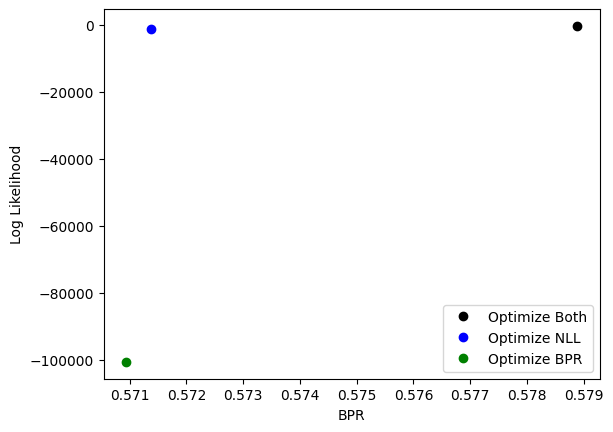

In [48]:
plt.plot([comb_det_bpr.detach()], [-comb_nll.detach()], 'ko', label='Optimize Both')
plt.plot([nll_det_bpr.detach()], [-nll_nll.detach()], 'bo', label='Optimize NLL')
plt.plot([bpr_det_bpr.detach()], [-bpr_nll.detach()], 'go', label='Optimize BPR')
plt.legend()
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')